In [206]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

# Set font for all plots to Liberation Sans
plt.rcParams["font.family"] = "Liberation Sans"

In [3]:
db = pd.read_csv('../Data/db.csv') # Load csv as a DataFrame
labels = list(db.columns)[2:] # Store the names of the features as a list

db_FP = pd.read_csv('../Data/db_FP.csv')
labels_FP = list(db_FP.columns)[2:]

The variable **labels_FP** contains the names of the *wannabe* independent variables, all estimated directly from FP signals. Legend:
- n = Maximum Peak Power
- l = Minimum Peak Power
- u = Mean Concentric Power
- z = Mean Eccentric Power

In [337]:
# Split Training-Set and Test-Set (75%/25%)
label_y = 'n_FP'
var = 'n'

X_train, X_test, y_train, y_test = train_test_split(db[labels], db_FP[label_y], 
                                    test_size = .25, random_state = 42)

# Normalize Training-Set and store mean and SD for each of the variables
X_train_n, MU, SIGMA = (X_train-X_train.mean())/X_train.std(), X_train.mean(), X_train.std() 

# Normalize Test-Set according to the mean and SD computed for the Training-Set
X_test_n = (X_test-MU) / SIGMA

print('Initial Dataset: %d jumps, %d features' % (db.shape[0], len(labels)))
print('Train-Set: %d jumps' % (X_train_n.shape[0]))
print('Test-Set: %d jumps' % (X_test_n.shape[0]))

Initial Dataset: 133 jumps, 26 features
Train-Set: 99 jumps
Test-Set: 34 jumps


Top most important features in each PC
PC1: 	['s']	0.294296
PC2: 	['D']	-0.348019
PC3: 	['q']	0.355476
PC4: 	['A']	0.455585
PC5: 	['q']	-0.474856
PC6: 	['i']	-0.646004
PC7: 	['F']	0.381805
PC8: 	['O']	-0.420089
PC9: 	['O']	-0.505374
PC10: 	['q']	-0.385987
PC11: 	['O']	0.497621


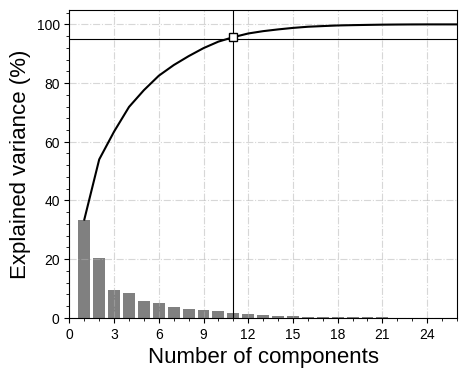

In [336]:
from sklearn.decomposition import PCA

pca = PCA()
# perform PCA on the scaled data
pca.fit(X_train_n)

# Extract the cumulated explained variance of the PCs
y_components = pca.explained_variance_ratio_.cumsum() * 100 
x_components = np.arange(1, len(y_components)+1)
# Find the minimum number of components for which the explained variance is at least 95%
min_pc = np.where(y_components > 95)[0][0]

## -- Check which feature contribute the most in each component -- ##
pca_components = abs(pca.components_)

v1, v2 = np.zeros(min_pc+1), []


print('Top most important features in each PC')
print('===============================================')
for row in range(min_pc+1):
    # get the indices of the top 4 values in each row
    temp = np.argpartition(-(pca_components[row]), 1)
    
    # sort the indices in descending order
    indices = temp[np.argsort((-pca_components[row])[temp])][:1]
    
    # Store the weight of the best feature for the current PC
    idx_best = np.argmax(abs(pca.components_[row]))
        
    # print the top 4 feature names
    print(f'PC{row+1}' + ': \t' + str(X_train_n.columns[indices].to_list()) + '\t' + str(np.round(pca.components_[row][idx_best], 6)))
    v1[row] = np.round(pca.components_[row][idx_best], 6)
    v2.append(labels[idx_best])
    
# Store Info about the best 'min_pc' components and the most important features for each of them
PC_DF = pd.DataFrame([v2, v1]).T
PC_DF.columns = ['Best Feature', 'Magnitude']
PC_DF.index = ['PC' + str(i) for i in range(1,min_pc+2)]
PC_DF.to_csv('PC_' + var + '.csv')

## -- Visualize Scree -- ##
# Scree Plot
fig, ax = plt.subplots(figsize=(5, 4))
plt.xlabel("Number of components", fontsize=16)
plt.ylabel("Explained variance (%)", fontsize=16)
plt.xlim(0, len(y_components + 1))
plt.bar(x_components, pca.explained_variance_ratio_ * 100, color = 'grey')
plt.plot(x_components, y_components, color = 'k')
plt.plot(95 * np.ones(len(y_components)+1), linestyle = '-', color = 'k', linewidth = .8)
plt.axvline(x = min_pc+1, color = 'k', linewidth = .8)
plt.plot(min_pc+1, y_components[min_pc], 's', color = 'black', markerfacecolor = 'w')

#minor_ticks = np.arange(0, 27)
# Change major ticks to show every 20.
ax.xaxis.set_major_locator(MultipleLocator(3))
ax.yaxis.set_major_locator(MultipleLocator(20))
ax.xaxis.set_minor_locator(AutoMinorLocator(3))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))

plt.grid('minor', alpha=.5, axis='x',linestyle = '-.')
plt.grid('major', alpha=.5, axis='x',linestyle = '-.')
plt.grid('major', alpha=.5, axis='y')
plt.grid('minor', alpha=.5, axis='y', linestyle = '-.')

plt.savefig('./img/PCA_Scree_' + var + '.svg', dpi=300)

In [338]:
X_train_pca = pd.DataFrame( pca.transform(X_train_n) )
X_train_pca.columns = ['PC' + str(i) for i in range(1,len(y_components)+1)]
X_train_pca.index = X_train_n.index

X_test_pca = pd.DataFrame( pca.transform(X_test_n) )
X_test_pca.columns = ['PC' + str(i) for i in range(1,len(y_components)+1)]
X_test_pca.index = X_test_n.index

In [5]:
# Lasso
from sklearn.linear_model import Lasso
from beautifultable import BeautifulTable
import scipy.stats as stats

lasso_model = Lasso(alpha=.1)
lasso_model.fit(X_train_n, y_train)
coefs_lasso = list(np.round(lasso_model.coef_, 2))
lasso_betas = pd.DataFrame(np.round(lasso_model.coef_,3), columns=["Beta"])
lasso_betas.index = labels
lasso_betas = lasso_betas[lasso_betas.Beta != 0] # Remove deleted variables
labels_lasso = list(lasso_betas.index) # Store the labels of the non null features

print('Total number of features maintained = %d' % lasso_betas.shape[0])
lasso_betas.T

Total number of features maintained = 16


,h,C,F,G,i,k,M,n,O,q,s,W,z,f3,f2,f1
Beta,0.948,0.698,-0.933,-0.02,0.812,0.088,-3.383,4.973,0.484,-2.744,-0.808,-0.148,-1.546,-2.355,1.77,-0.486


In [6]:
# Store in memory the new Train and Test set with the Lasso-selected variables only
X_train_new = X_train_n[labels_lasso]
X_test_new = X_test_n[labels_lasso]

In [339]:
## Initialize GridSearch for all the models
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

## -- Initialize 'empty' models -- ##
kNN = KNeighborsRegressor()
SVM = SVR()
RF = RandomForestRegressor(random_state=0)
MLP = MLPRegressor(random_state=0)

#### ---- Parameter Grids ---- ####
## -- kNN -- ##
n_neighbors = np.arange(1,min_pc)
weights = ['uniform', 'distance']
algorithm = ['auto', 'ball_tree']
leaf_size = np.arange(1,min_pc)

kNN_param_grid = {'n_neighbors': n_neighbors,
                  'weights': weights,
                  'algorithm': algorithm,
                  'leaf_size': leaf_size}

kNN_gscv = GridSearchCV(kNN, kNN_param_grid, cv=5, scoring='neg_mean_absolute_error')

## -- SVM -- ##
SVM_param_grid = {'kernel': ('linear', 'poly', 'rbf', 'sigmoid'), 
                  'C': np.round( np.arange(1., 2.1, .1), 2),
                  'gamma': ['auto', 'scale'],
                  'epsilon': np.round( np.arange(0.1, 1.1, .1), 2)}

SVM_gscv = GridSearchCV(SVM, SVM_param_grid, cv=5, scoring='neg_mean_absolute_error')

## -- RF -- ##
RF_param_grid = {'n_estimators': np.arange(1, min_pc+1),
                 'criterion': ['squared_error', 'absolute_error', 'poisson'],
                 'min_samples_split': np.arange(1,10),
                 'max_features': ['sqrt', 'log2', None],
                 'ccp_alpha': np.arange(.0, 1.1, .1)}

RF_gscv = GridSearchCV(RF, RF_param_grid, cv=5, scoring='neg_mean_absolute_error')

## -- MLP -- ##
MLP_param_grid = {'activation' : ['identity', 'logistic', 'tanh', 'relu'],
                  'solver' : ['lbfgs', 'sgd', 'adam'],
                  'hidden_layer_sizes': np.arange(1,min_pc)}

MLP_gscv = GridSearchCV(MLP, MLP_param_grid, cv=5, scoring='neg_mean_absolute_error')
#### ---- END PARAMETER GRIDS ---- ####

In [1]:
(10 * 2 * 2 * 10) + (4 * 10 * 2 * 10) + (11 * 3 * 10 * 3 * 10) + (4 * 3 * 10)

11220

In [ ]:
#### ---- RUN GRIDSEARCH FOR ALL MODELS ---- ####
print('Starting kNN')
kNN_gscv.fit(X_train_pca, y_train)
print('GridSearchCV completed for kNN')

print('Starting SVM')
SVM_gscv.fit(X_train_pca, y_train)
print('GridSearchCV completed for SVM')

print('Starting RF')
RF_gscv.fit(X_train_pca, y_train)
print('GridSearchCV completed for RF')

print('Starting MLP')
MLP_gscv.fit(X_train_pca, y_train)
print('GridSearchCV completed for MLP')
## -- SAVE THE MODELS -- ##
import pickle

pickle.dump(kNN_gscv, open('./best_models/kNN_' + var + '.sav', 'wb'))
pickle.dump(SVM_gscv, open('./best_models/SVM_' + var + '.sav', 'wb'))
pickle.dump(RF_gscv, open('./best_models/RF_' + var + '.sav', 'wb'))
pickle.dump(MLP_gscv, open('./best_models/MLP_' + var + '.sav', 'wb'))

In [303]:
# https://datascience.stackexchange.com/questions/29495/how-to-estimate-gridsearchcv-computing-time
def compute_gscv_time(gscv):
    mean_fit_time= gscv.cv_results_['mean_fit_time']
    mean_score_time= gscv.cv_results_['mean_score_time']
    n_splits  = gscv.n_splits_ #number of splits of training data
    n_iter = pd.DataFrame(gscv.cv_results_).shape[0] #Iterations per split

    return np.round(np.mean(mean_fit_time + mean_score_time) * n_splits * n_iter, 3)

In [341]:
#### ---- STORE HYPERPARAMETERS INTO .CSV READY FOR PAPER TABLE ---- ####
with open('GridSearch_Results_' + var + '.csv', 'w') as f:
    
    f.write('Architecture,Hyperparameter,Best Choice\n')
    f.write('kNN')
        
    l = list(kNN_gscv.best_params_.keys())
    for item in l:
        f.write(',' + item + ',' + str(kNN_gscv.best_params_.get(item)) + '\n')
        
    f.write(',elapsed time,' + str(compute_gscv_time(kNN_gscv)) + '\n')
            
    f.write('SVM')
        
    l = list(SVM_gscv.best_params_.keys())
    for item in l:
        f.write(',' + item + ',' + str(SVM_gscv.best_params_.get(item)) + '\n')
        
    f.write(',elapsed time,' + str(compute_gscv_time(SVM_gscv)) + '\n')
            
    f.write('RF')
        
    l = list(RF_gscv.best_params_.keys())
    for item in l:
        f.write(',' + item + ',' + str(RF_gscv.best_params_.get(item)) + '\n')
        
    f.write(',elapsed time,' + str(compute_gscv_time(RF_gscv)) + '\n')
            
    f.write('MLP')
        
    l = list(MLP_gscv.best_params_.keys())
    for item in l:
        f.write(',' + item + ',' + str(MLP_gscv.best_params_.get(item)) + '\n')
        
    f.write(',elapsed time,' + str(compute_gscv_time(MLP_gscv)))

In [32]:
import sys
import pickle

## -- Load the models -- ##
kNN_gscv = pickle.load(open('./best_models/kNN_' + var + '.sav', 'rb'))
SVM_gscv = pickle.load(open('./best_models/SVM_' + var + '.sav', 'rb'))
RF_gscv = pickle.load(open('./best_models/RF_' + var + '.sav', 'rb'))
MLP_gscv = pickle.load(open('./best_models/MLP_' + var + '.sav', 'rb'))

In [342]:
## -- Make the estimates on the test set now -- ##
kNN = kNN_gscv.best_estimator_
SVM = SVM_gscv.best_estimator_
RF = RF_gscv.best_estimator_
MLP = MLP_gscv.best_estimator_

kNN.fit(X_train_pca, y_train)
SVM.fit(X_train_pca, y_train)
RF.fit(X_train_pca, y_train)
MLP.fit(X_train_pca, y_train)

y_hat_kNN = kNN.predict(X_test_pca)
y_hat_SVM = SVM.predict(X_test_pca)
y_hat_RF = RF.predict(X_test_pca)
y_hat_MLP = MLP.predict(X_test_pca)

/home/maskul/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fae686095e0>
Traceback (most recent call last):
  File "/home/maskul/miniconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/maskul/miniconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/maskul/miniconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/maskul/miniconda3/lib/python3.9/site-packages/threadpoolctl.py", l

In [357]:
Out_pca = pd.DataFrame([y_test.values, X_test[var].values, y_hat_kNN, y_hat_SVM, y_hat_RF, y_hat_MLP]).T
Out_pca.columns = ['FP', 'IMU', 'kNN', 'SVM', 'RF', 'MLP']

     Accuracy  Precision  RMSD%  Bias     LB     UB
IMU      8.05       7.01  19.42  3.96  -9.77  17.70
kNN      4.57       4.53  16.31 -0.59  -9.47   8.30
SVM      3.83       3.80  11.45  0.53  -6.91   7.97
RF       6.68       6.49  22.23 -1.56 -14.28  11.17
MLP      3.87       3.87  11.96  0.26  -7.31   7.84


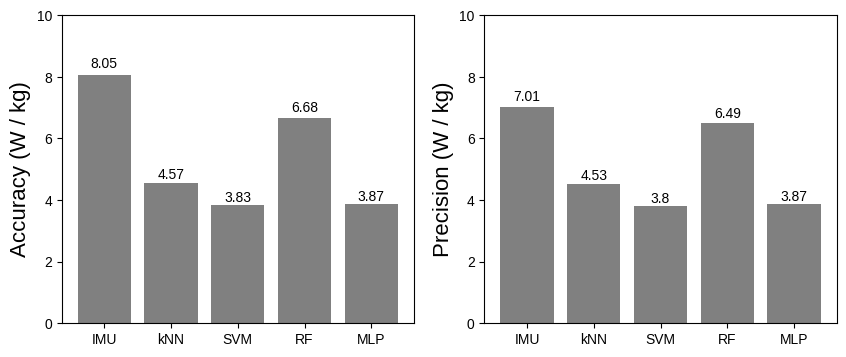

In [358]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]+.03*y[i], y[i], ha = 'center')
def print_results(Y, var_n):
    
    v = list(Y.columns)
    y = Y[v[0]].values

    acc, prec, rmsdp, b, lb, ub = np.zeros(len(v)-1), np.zeros(len(v)-1), np.zeros(len(v)-1), np.zeros(len(v)-1), np.zeros(len(v)-1), np.zeros(len(v)-1)

    for i in range(1, len(v)):
        acc[i-1] = np.sqrt( np.mean( (y - Y[v[i]]) ** 2 ) )
        prec[i-1] = np.std(y - Y[v[i]])
        rmsdp[i-1] = np.sqrt( (1 / Y.shape[0]) * np.sum((( Y[v[i]] / y ) - 1) ** 2) ) * 100
        b[i-1] = np.mean( y - Y[v[i]] )
        lb[i-1] = b[i-1] - 1.96 * prec[i-1]
        ub[i-1] = b[i-1] + 1.96 * prec[i-1]

    TBL = pd.DataFrame(np.round([acc, prec, rmsdp, b, lb, ub], 2)).T
    TBL.columns = ['Accuracy', 'Precision', 'RMSD%', 'Bias', 'LB', 'UB']
    TBL.index = v[1:]
    TBL.to_csv('TBL_' + var_n + '.csv')
    
    plt.figure(figsize=(10,4))
    plt.subplot(121)
    plt.ylim([0, 10])
    plt.ylabel('Accuracy (W / kg)', fontsize=16)
    plt.bar(list(TBL.index), TBL['Accuracy'], color = 'grey')
    addlabels(list(TBL.index), TBL['Accuracy'])
    plt.subplot(122)
    plt.ylabel('Precision (W / kg)', fontsize=16)
    plt.bar(list(TBL.index), TBL['Precision'], color = 'grey')
    addlabels(list(TBL.index), TBL['Precision'])
    plt.ylim([0, 10])
    
    print(TBL)

    plt.savefig('./img/acc_prec_' + var + '.svg', dpi=300)

print_results(Out_pca, var)

In [352]:
from sklearn.multioutput import MultiOutputRegressor

y_comb = pd.DataFrame([db_FP['n_FP'][y_train.index], db_FP['u_FP'][y_train.index]]).T
regr = MultiOutputRegressor(SVM)

regr.fit(X_train_pca,y_comb)
y_hat_comb = regr.predict(X_test_pca)